In [ ]:
# default_exp modelling

# Modelling & submitting

> Playing with different models and submitting predictions over the test set to kaggle. 

Current implementation of this notebook leads to (private leaderboard score): 
- baseline (linear regression on dep_var_stats and meter 1hot) 1.7
- RandomForest, tabular_learner, lgbm at ~1.45, 
- ensembling tabular_learner, RandomForest and lgbm gives ~1.4

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from ashrae import loading, preprocessing, feature_testing

import pandas as pd
from pathlib import Path
import os
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import typing
import pickle


from sklearn import linear_model, tree, model_selection, ensemble

from fastai.tabular.all import *

import lightgbm as lgb

import ipywidgets as widgets

/mnt/c/Programs_wsl2/miniconda3/envs/py38_fastai/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
import tqdm
from multiprocessing import Pool

In [4]:
pd.options.plotting.backend = "plotly"

In [5]:
do_test = True
do_submit = False
data_path = loading.DATA_PATH

In [6]:
loading.N_TRAIN = 100_000
loading.N_TEST = 100_000

Loading from scratch

In [7]:
%%time
ashrae_data = loading.load_all()

2020-11-27 18:32:14.980 | INFO     | ashrae.loading:get_csvs:36 - Collected csv paths: {Path('../data/ashrae-energy-prediction-publicleaderboard.csv'): 'public-leaderboard', Path('../data/building_metadata.csv'): 'building', Path('../data/my_submission.csv'): None, Path('../data/sample_submission.csv'): None, Path('../data/test.csv'): 'test', Path('../data/train.csv'): 'train', Path('../data/weather_test.csv'): 'weather_test', Path('../data/weather_train.csv'): 'weather_train'}
2020-11-27 18:32:26.867 | INFO     | ashrae.loading:get_meter_data:44 - Loading meter data: ../data/train.csv
2020-11-27 18:32:55.414 | INFO     | ashrae.loading:get_meter_data:44 - Loading meter data: ../data/test.csv
2020-11-27 18:32:55.435 | INFO     | ashrae.loading:test_meter_train_and_test_set:80 - Passed basic meter info tests
2020-11-27 18:32:55.436 | INFO     | ashrae.loading:get_building_data:87 - Loading building data: ../data/building_metadata.csv
2020-11-27 18:32:55.453 | INFO     | ashrae.loading:t

CPU times: user 29.2 s, sys: 2.23 s, total: 31.5 s
Wall time: 41.1 s


Takes about 3min30

In [12]:
%%time
processor = preprocessing.Processor() # t_train=t_train
tfms_config = {
#     'fix_bid_363':{},
#     'fix_bid_1099':{'threshold': 10.},
#     'remove_bad_meter0_readings_of_first_141days': {},
#     'remove_not_summer_0s_meter_2_and_3': {},
#     'remove_0s_meter0': {},
#     'remove_outliers':{'f':10,'dep_var':'meter_reading'},
#     'remove_imputed_weeks':{'dep_var':'meter_reading'},
#     'add_dep_var_stats':{},
    'add_random_noise_features':{},
    'add_time_features':{},
#     'add_polar_transformed_features_multiple_cols':{'cols':['timestampHour', 'timestampDayofyear'], 'bounds':[(0,24), (1,365)]}},
    'add_weather_features':{'fix_time_offset':True,
                            'add_na_indicators':True,
                            'impute_nas':True},
    'add_building_features':{},
    'convert_kBTU_to_kWh':{},
#     'add_onehot_encoded':{},
}

df, var_names = processor(ashrae_data['meter_train'], tfms_configs=tfms_config,
                          df_weather=ashrae_data['weather_train'],
                          df_building=ashrae_data['building'])
display(df.head(), var_names)

%time
df_test, _ = processor(ashrae_data['meter_test'], tfms_configs=tfms_config,
                         df_weather=ashrae_data['weather_test'],
                         df_building=ashrae_data['building'])
df_test = preprocessing.align_test(df, var_names, df_test)

2020-11-27 18:43:18.702 | INFO     | ashrae.preprocessing:add_random_noise_features:361 - Added noise feature: 
	continuous: ['random_noise']
2020-11-27 18:43:18.817 | INFO     | ashrae.preprocessing:add_time_features:478 - Added categorical time features: ['timestampMonth', 'timestampDay', 'timestampWeek', 'timestampDayofweek', 'timestampDayofyear', 'timestampIs_month_end', 'timestampIs_month_start', 'timestampIs_quarter_start', 'timestampIs_quarter_end', 'timestampIs_year_start', 'timestampIs_year_end', 'timestampHour', 'timestampIs_us_holiday']
2020-11-27 18:43:19.917 | INFO     | ashrae.preprocessing:add_weather_features:454 - Added weather features: 
	categorical: ['air_temperature_na(processor)', 'cloud_coverage_na(processor)', 'dew_temperature_na(processor)', 'precip_depth_1_hr_na(processor)', 'sea_level_pressure_na(processor)', 'wind_direction_na(processor)', 'wind_speed_na(processor)']
	continuous: ['wind_direction', 'air_temperature', 'dew_temperature', 'precip_depth_1_hr', '

,building_id,meter,timestamp,timestampWeek,meter_reading_log1p,random_noise,timestampMonth,timestampDay,timestampDayofweek,timestampDayofyear,...,dew_temperature_na(processor),precip_depth_1_hr_na(processor),sea_level_pressure_na(processor),wind_direction_na(processor),wind_speed_na(processor),site_id,primary_use,square_feet,year_built,floor_count
0,234,1,2016-04-04 15:00:00,14,6.714997,0.911579,4,4,0,95,...,False,False,False,False,False,2,Education,179167,1971.0,NaN
1,740,0,2016-03-14 12:00:00,11,0.000400,-1.545337,3,14,0,74,...,False,True,True,False,False,5,Education,37975,1976.0,1.0
2,169,0,2016-08-09 16:00:00,32,6.448066,-1.694625,8,9,1,222,...,False,False,False,False,False,2,Education,179559,2006.0,NaN
3,317,0,2016-09-10 04:00:00,36,3.766766,0.558248,9,10,5,254,...,False,False,False,False,False,3,Office,16098,NaN,NaN
4,1394,2,2016-07-22 01:00:00,29,4.995772,0.218147,7,22,4,204,...,False,True,False,False,False,15,Entertainment/public assembly,16351,2002.0,NaN


{'conts': ['random_noise',
  'wind_direction',
  'air_temperature',
  'dew_temperature',
  'precip_depth_1_hr',
  'sea_level_pressure',
  'wind_speed',
  'cloud_coverage',
  'square_feet',
  'year_built',
  'floor_count'],
 'cats': ['building_id',
  'meter',
  'timestampMonth',
  'timestampDay',
  'timestampWeek',
  'timestampDayofweek',
  'timestampDayofyear',
  'timestampIs_month_end',
  'timestampIs_month_start',
  'timestampIs_quarter_start',
  'timestampIs_quarter_end',
  'timestampIs_year_start',
  'timestampIs_year_end',
  'timestampHour',
  'timestampIs_us_holiday',
  'air_temperature_na(processor)',
  'cloud_coverage_na(processor)',
  'dew_temperature_na(processor)',
  'precip_depth_1_hr_na(processor)',
  'sea_level_pressure_na(processor)',
  'wind_direction_na(processor)',
  'wind_speed_na(processor)',
  'site_id',
  'primary_use'],
 'dep_var': 'meter_reading_log1p'}

2020-11-27 18:43:20.081 | INFO     | ashrae.preprocessing:add_random_noise_features:361 - Added noise feature: 
	continuous: ['random_noise']
2020-11-27 18:43:20.190 | INFO     | ashrae.preprocessing:add_time_features:478 - Added categorical time features: ['timestampMonth', 'timestampDay', 'timestampWeek', 'timestampDayofweek', 'timestampDayofyear', 'timestampIs_month_end', 'timestampIs_month_start', 'timestampIs_quarter_start', 'timestampIs_quarter_end', 'timestampIs_year_start', 'timestampIs_year_end', 'timestampHour', 'timestampIs_us_holiday']


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


2020-11-27 18:43:22.380 | INFO     | ashrae.preprocessing:add_weather_features:454 - Added weather features: 
	categorical: ['air_temperature_na(processor)', 'cloud_coverage_na(processor)', 'dew_temperature_na(processor)', 'precip_depth_1_hr_na(processor)', 'sea_level_pressure_na(processor)', 'wind_direction_na(processor)', 'wind_speed_na(processor)']
	continuous: ['wind_direction', 'air_temperature', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed', 'cloud_coverage']
2020-11-27 18:43:22.415 | INFO     | ashrae.preprocessing:add_building_features:377 - Added building features: 
	categorical: ['site_id', 'primary_use']
	continuous: ['square_feet', 'year_built', 'floor_count']
2020-11-27 18:43:22.416 | INFO     | ashrae.preprocessing:convert_kBTU_to_kWh:603 - converted meter readings for meter 0 and site_id 0 from kBTU to kWh
2020-11-27 18:43:22.510 | INFO     | ashrae.preprocessing:__call__:142 - Reduced samples by 0 rows = 0.00 %


CPU times: user 3.83 s, sys: 0 ns, total: 3.83 s
Wall time: 3.82 s


In [ ]:
%%time
# df.to_parquet(data_path/'X.parquet')
# df_test.to_parquet(data_path/'X_test.parquet')
# pickle.dump(var_names, open(data_path/'var_names.pkl', 'wb'))

In [13]:
#export
def evaluate_torch(y_true:torch.Tensor, y_pred:torch.Tensor): return torch.sqrt(F.mse_loss(y_true, y_pred))

cnr = lambda x: x.clone().numpy().ravel() # clone numpy ravel

## Loading

In [ ]:
%%time
# var_names = preprocessing.load_var_names(data_path/'var_names.pckl')
# var_names

In [ ]:
%%time
# df = preprocessing.load_df(data_path/'X.parquet') #.sample(100000)

# if do_test:
#     df_test = preprocessing.load_df(data_path/'X_test.parquet') #.sample(100000)

In [ ]:
len(df), len(df_test)

## Sampling `df`

In [14]:
%%time
n = len(df)

if False: # per building_id and meter sampling
    n_sample_per_bid = 500
    replace = True

    df = (df.groupby(['building_id', 'meter'])
         .sample(n=n_sample_per_bid, replace=replace))

if False: # general sampling
    frac_samples = .1
    replace = False

    df = (df.sample(frac=frac_samples, replace=replace))

print(f'using {len(df)} samples = {len(df)/n*100:.2f} %')

using 100000 samples = 100.00 %
CPU times: user 428 µs, sys: 71 µs, total: 499 µs
Wall time: 304 µs


## Split

Split settings

In [15]:
%%time
# t_train = pd.read_parquet(data_path/'t_train.parquet')
t_train = None

%time
#split_kind = 'random'
#split_kind = 'time'
# split_kind = 'fix_time'
split_kind = 'time_split_day'
train_frac = .9

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs
CPU times: user 542 µs, sys: 91 µs, total: 633 µs
Wall time: 360 µs


Splitting

In [16]:
splits = preprocessing.split_dataset(df, split_kind=split_kind, train_frac=train_frac,
                                     t_train=t_train)
print(f'sets {len(splits)}, train {len(splits[0])} = {len(splits[0])/len(df):.4f}, valid {len(splits[1])} = {len(splits[1])/len(df):.4f}')

sets 2, train 89757 = 0.8976, valid 10243 = 0.1024


In [ ]:
var_names

In [ ]:
var_names_no_anns = {
    'dep_var': var_names['dep_var'],
    'conts': [v for v in var_names['conts'] if 'meter_reading' in v],
    'cats': [v for v in var_names['cats'] if v.startswith('meter_')]
}
var_names_no_anns

In [ ]:
var_names_anns = {
    'dep_var': var_names['dep_var'],
    'conts': var_names['conts'],
    'cats': [v for v in var_names['cats'] if not v.startswith('meter_')]
}
var_names_anns

Takes about 6 minutes on 100% of the data

In [19]:
%%time
procs = [Categorify, FillMissing, Normalize]
to = feature_testing.get_tabular_object(df,
                                        var_names,
                                        splits=splits,
                                        procs=procs)

CPU times: user 1.49 s, sys: 0 ns, total: 1.49 s
Wall time: 1.51 s


Storing `to`

In [ ]:
%%time
# pickle.dump(to, open(data_path/'to.pkl', 'wb'))

Loading `to`

In [ ]:
%%time
# to = pickle.load(open(data_path/'to.pkl', 'rb'))

Creating data loaders

In [20]:
%%time
train_bs = 1000
val_bs = 1000

dls = to.dataloaders(bs=train_bs, val_bs=val_bs)

CPU times: user 11.7 ms, sys: 0 ns, total: 11.7 ms
Wall time: 11.8 ms


Saving dls

In [ ]:
%%time
# torch.save(dls, data_path/'dls.pkl')

Warning: Takes about 14min with the test set

In [21]:
%%time
test_bs = 1000

if do_test:
    test_dl = dls.test_dl(df_test, bs=test_bs) 

CPU times: user 1.42 s, sys: 0 ns, total: 1.42 s
Wall time: 1.42 s


In [ ]:
%%time
# torch.save(test_dl, data_path/'test_dl.pkl')

Loading dls

In [ ]:
%%time
# dls = torch.load(data_path/'dls.pkl')

In [ ]:
%%time
# test_dl = torch.load(data_path/'test_dl.pkl')

## Modelling with

### `fastai`

Fastai finding: make sure your test set values are not out of domain $\Rightarrow$ `timestampYear` in this notebook is put into the training set but there only takes on the value 2016.0, but in the test set it's 2017.0 and 2018.0, causing the predictions to zero out everywhere.

In [ ]:
np.min([to.train.ys.values.min(), to.valid.ys.values.min()]), np.max([to.train.ys.values.max(), to.valid.ys.values.max()])

In [22]:
y_range = None #(-.1, 17)

# layers = [4000, 2000, 1000, 500, 250]
layers = [50, 20] # [1600, 800, 400, 200]

# embed_p = .01
embed_p = 0.

# ps = [.1, .1, .1, .1, .1]
ps = [.0 for _ in layers]
# ps[0] = .2

# config = None
config = tabular_config(embed_p=embed_p, ps=ps,
#                         act_cls=Swish(inplace=True)
                        )
# config = tabular_config(act_cls=nn.ReLU(inplace=True))
# config = tabular_config(act_cls=Swish(inplace=True))
# config = tabular_config(act_cls=Sine(inplace=True))

learn = tabular_learner(dls, y_range=y_range, 
                        layers=layers, n_out=1, 
                        config=config, 
#                         wd=.01,
                        loss_func=evaluate_torch) #.to_fp16()
run = -1 # a counter for `fit_one_cycle` executions

In [ ]:
%%time
# learn.save('1600-800-400-200')

In [ ]:
%%time
# learn = learn.load('1600-800-400-200')

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.013182567432522774)

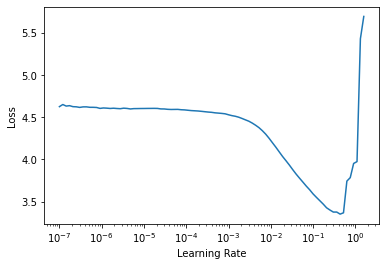

In [23]:
learn.lr_find()

In [24]:
run += 1
print(f'run #{run}')
learn.fit_one_cycle(5, lr_max=4e-2)

run #0


epoch,train_loss,valid_loss,time
0,1.842221,1.579847,00:08
1,1.292805,1.104238,00:08
2,1.082080,1.017250,00:11
3,0.980425,0.964385,00:11
4,0.901918,0.945074,00:11


In [25]:
%%time
y_valid_pred, y_valid_true = learn.get_preds()
y_valid_pred_fast = cnr(y_valid_pred)

CPU times: user 645 ms, sys: 41.3 ms, total: 686 ms
Wall time: 188 ms


In [26]:
nb_score = evaluate_torch(y_valid_true, 
                          y_valid_pred).item()
print(f'fastai loss {nb_score:.4f}')

fastai loss 0.9462


In [27]:
%%time
if do_test:
    y_test_pred, _ = learn.get_preds(dl=test_dl)
    y_test_pred_fast = cnr(y_test_pred)
    y_test_pred = cnr(y_test_pred)

CPU times: user 3.23 s, sys: 129 ms, total: 3.36 s
Wall time: 852 ms


In [28]:
y_valid_pred, y_valid_true = cnr(y_valid_pred), cnr(y_valid_true)

replacing categorical features for trees with learned embeddings

In [ ]:
trees_with_embeddings = False

In [ ]:
if trees_with_embeddings:
    X_emb_train = to.train.xs.copy()
    X_emb_val = to.valid.xs.copy()

In [ ]:
#export
class EmbeddingFeatures:
    def __init__(self, to:TabularPandas, learn:Learner):        
        self.df_embs = {col: self.get_embedding_features_df(col, to, learn) for col in to.cat_names}

    def get_embedding_features_df(self, col:str, to:TabularPandas, learn:Learner): # , to:TabularPandas, learn:Learner
        ix = to.cat_names.index(col)
        w_emb = learn.model.embeds[ix].weight.cpu().detach().clone().numpy()
        df_emb = (pd.DataFrame(w_emb)
                  .add_prefix(f'{col}_embedding_'))
        df_emb.index.rename(col, inplace=True)
        return df_emb

In [ ]:
%%time
ef = EmbeddingFeatures(to, learn)

In [ ]:
ef.df_embs['building_id'].iloc[:5,:3]

In [ ]:
#export
@patch
def replace_cat_features_with_embeddings(self:EmbeddingFeatures, X:pd.DataFrame):
    for col, df_emb in self.df_embs.items():
        X = X.join(df_emb, on=col, how='left').drop(columns=col)
    return X

In [ ]:
%%time
if trees_with_embeddings:
    X_emb_train = ef.replace_cat_features_with_embeddings(X_emb_train)
    X_emb_val = ef.replace_cat_features_with_embeddings(X_emb_val)

### `sklearn`

In [ ]:
%%time
params = {'n_estimators': 20, 'max_features': 'sqrt', 'n_jobs':1}
model = ensemble.RandomForestRegressor
# params = {}
# model = linear_model.LinearRegression

m = model(**params)

In [ ]:
%%time
if trees_with_embeddings:
    m.fit(X_emb_train, to.train.ys.values.ravel())
else:
    m.fit(to.train.xs.values, to.train.ys.values.ravel())

In [ ]:
#export
@patch
def embedding_assignment_func(self:EmbeddingFeatures, stuff:tuple):
    k, grp = stuff
    grp.drop(columns=['group'], inplace=True)
    grp = self.replace_cat_features_with_embeddings(grp)
    return pd.Series(m.predict(grp.values), index=grp.index)

@patch
def predict_with_embeddings(self:EmbeddingFeatures, X:pd.DataFrame, m,
                            num_rows:int=2_000_000, num_workers:int=1):
    tmp = X.copy()
    tmp['group'] = np.floor(tmp.index.values / num_rows).astype(int)
    n = int(np.ceil(len(tmp)/num_rows))
    y_test_pred = []
    
    if num_workers > 1:
        pool = Pool(processes=num_workers)
        for grp in tqdm.tqdm(pool.imap(self.embedding_assignment_func, tmp.groupby('group')), total=n):
            y_test_pred.append(grp)
        pool.join()
        pool.close()
    else:
        for stuff in tqdm.tqdm(tmp.groupby('group'), total=n):
            y_test_pred.append(self.embedding_assignment_func(stuff))
    
    y_test_pred = pd.concat(y_test_pred)
    display(y_test_pred.head(), y_test_pred.tail())
    return y_test_pred.sort_index()

In [ ]:
%%time
if trees_with_embeddings:
    y_valid_pred = m.predict(X_emb_val)
else:
    y_valid_pred = m.predict(to.valid.xs.values)

y_valid_pred_sk = np.copy(y_valid_pred)

> Note: the prediction with embeddings takes ~ 37 minutes.

In [ ]:
%%time
if do_test:
    if trees_with_embeddings:
        y_test_pred = ef.predict_with_embeddings(test_dl.xs, m.set_params(n_jobs=-1), 
                                                 num_workers=1)
    else:
        y_test_pred = m.predict(test_dl.xs)
    y_test_pred_sk = np.copy(y_test_pred)

In [ ]:
y_valid_true = to.valid.ys.values.ravel()
nb_score = evaluate_torch(torch.from_numpy(y_valid_true), 
                          torch.from_numpy(y_valid_pred)).item()
print(f'sklearn loss {nb_score:.4f}')

### `lightgbm`

In [ ]:
%%time
if trees_with_embeddings:
    lgb_train = lgb.Dataset(X_emb_train, to.train.ys.values.ravel())
    lgb_eval = lgb.Dataset(X_emb_val, to.valid.ys.values.ravel(), 
                           reference=lgb_train)
else:
    lgb_train = lgb.Dataset(to.train.xs.values, to.train.ys.values.ravel())
    lgb_eval = lgb.Dataset(to.valid.xs.values, to.valid.ys.values.ravel(), 
                           reference=lgb_train)

In [ ]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 42,
    'learning_rate': 0.5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [ ]:
%%time
gbm = lgb.train(params, lgb_train,
                num_boost_round=10,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

In [ ]:
%%time
if trees_with_embeddings:
    y_valid_pred_lgbm = gbm.predict(X_emb_val,
                                    num_iteration=gbm.best_iteration)
else:
    y_valid_pred_lgbm = gbm.predict(to.valid.xs.values,
                                    num_iteration=gbm.best_iteration)

y_valid_pred = np.copy(y_valid_pred_lgbm)

In [ ]:
%%time
if do_test:
    if trees_with_embeddings:
        y_test_pred_lgbm = gbm.predict(X_emb_test,
                                       num_iteration=gbm.best_iteration)
    else:
        y_test_pred_lgbm = gbm.predict(test_dl.xs.values,
                                       num_iteration=gbm.best_iteration)
    y_test_pred = np.copy(y_test_pred_lgbm)

In [ ]:
y_valid_true = to.valid.ys.values.ravel()
nb_score = evaluate_torch(torch.from_numpy(y_valid_true), 
                          torch.from_numpy(y_valid_pred)).item()
print(f'lgbm loss {nb_score:.4f}')

## Ensembling

In [ ]:
y_valid_pred = np.mean([
    y_valid_pred_sk, 
    y_valid_pred_fast,
    y_valid_pred_lgbm
], axis=0)
y_valid_true = to.valid.ys.values.ravel()
nb_score = evaluate_torch(torch.from_numpy(y_valid_true), 
                          torch.from_numpy(y_valid_pred)).item()
print(f'ensembling loss {nb_score:.4f}')

In [ ]:
%%time
if do_test:
    y_test_pred = np.mean([
        y_test_pred_sk, 
        y_test_pred_fast, 
        y_test_pred_lgbm
    ], axis=0)

## Inspecting

### `dep_var` distribution

Train vs validation distributions

In [ ]:
#export
def pick_random(x,s:int=50): return np.random.choice(x.ravel(), size=s, replace=False)

In [ ]:
feature_testing.hist_plot_preds(pick_random(y_valid_true), 
                                pick_random(y_valid_pred), 
                                label0='truth', label1='prediction')

In [ ]:
if do_test:
    feature_testing.hist_plot_preds(pick_random(y_valid_true), 
                                    pick_random(y_test_pred), 
                                    label0='truth (validation)', 
                                    label1='prediction (test set)').show()

### Boldly wrong predictions

In [ ]:
%%time
miss_cols = [v for v in ['building_id', 'meter','timestamp'] if v not in to.valid.xs.columns]
tmp = to.valid.xs.join(df.loc[:,miss_cols]) if len(miss_cols)>0 else to.valid.xs
bwt = feature_testing.BoldlyWrongTimeseries(tmp, y_valid_true, y_valid_pred)

In [ ]:
bwt.run_boldly()

## Submission to kaggle

In [33]:
test_dl.classes

{'building_id': ['#na#', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 

In [38]:
test_dl.classes['meter'].o2i['#na']

0

In [39]:
%%time
if do_test:
    y_test_pred_original = torch.exp(tensor(y_test_pred)) - 1

    y_out = pd.DataFrame(cnr(y_test_pred_original),
                         columns=['meter_reading'],
                         index=test_dl.xs.index)
    
    # for meter 0 readings of site 0 buildings
    y_out = y_out.join(test_dl.xs.loc[:,['building_id', 'meter']])

    _meter = test_dl.classes['meter'].o2i[0]
    _bids = [test_dl.classes['building_id'].o2i[_bid] for _bid in preprocessing.site0_bids]
    y_out = preprocessing.convert_meter_reading(y_out, _bids,
                                                preprocessing.kWh_to_kBTU,
                                                meter=_meter)
    y_out.drop(columns=['building_id', 'meter'], inplace=True)
    display(y_out.head())

    assert len(y_out) == 41697600

'before rescaling'

,meter_reading
row_id,
8806925,68.210304
35102001,24.198999
21876748,6.581793
2575372,51.853706
25127301,11.948301


'after joining'

,meter_reading,building_id,meter
row_id,,,
8806925,68.210304,492,1
35102001,24.198999,1234,4
21876748,6.581793,942,1
2575372,51.853706,138,1
25127301,11.948301,1018,2


'after rescaling'

,meter_reading,building_id,meter
row_id,,,
8806925,68.210304,492,1
35102001,24.198999,1234,4
21876748,6.581793,942,1
2575372,51.853706,138,1
25127301,11.948301,1018,2


,meter_reading
row_id,
8806925,68.210304
35102001,24.198999
21876748,6.581793
2575372,51.853706
25127301,11.948301


AssertionError: 

> Note: Writing to csv takes ~2min

In [ ]:
%%time
if do_submit:
    y_out.to_csv(data_path/'my_submission.csv',
                 float_format='%.4f')

`kaggle competitions submit -c ashrae-energy-prediction -f submission.csv -m "Message"`

In [ ]:
#export
def pretty_dictionary(d:dict): return ', '.join(f'{k} = {v}' for k,v in d.items())

In [ ]:
act = 'ReLu'

# lin_model_msg = f'baseline (linear regression)'
rf_model_msg = f'RandomForest: {pretty_dictionary(params)}'
if trees_with_embeddings:
    rf_model_msg += ' (with embeddings)'
lgbm_model_msg = f'LGBM: {pretty_dictionary(params)}'

fast_model_msg = f'tabular_learner (run #{run}): act {act}, layers {layers}, ps {ps}, embed_p {embed_p}'

# model_msg = f'Ensembling tabular_learner and RandomForest ({fast_model_msg}, {rf_model_msg})'
model_msg = f'Ensembling LGBM, tabular_learner and RandomForest ({lgbm_model_msg}, {fast_model_msg}, {rf_model_msg})'
# model_msg = rf_model_msg
# model_msg = lgbm_model_msg

split_msg = f'split kind "{split_kind}" N_TRAIN {loading.N_TRAIN}'
samples_msg = f'num samples {len(dls.xs)} = {len(dls.xs)/20216100/2*100:.2f} %'
features_msg = f'weather and building features'
score_msg = f'nb score {nb_score:.4f}'
# message = ['baseline (linear regression on dep_var_stats and 1hot meter) ', '500 obs/bid', f'nb score {nb_score:.4f}']
# message = ['random forest', '500 obs/bid', 'all features', f'nb score {nb_score:.4f}']
# message = ['lightgbm', '500 obs/bid', '100 rounds', '42 leaves', 'lr .5', f'nb score {nb_score:.4f}']
# message = ['tabular_learner', '500 obs/bid', 'all features', f'layers {layers}, embed_p .1, ps [.1,.1,.1]', f'nb score {nb_score:.4f}']
message = ' + '.join([model_msg, samples_msg, split_msg, features_msg, score_msg])
message

In [ ]:
if do_test and do_submit:
    print('Submitting...')
    !kaggle competitions submit -c ashrae-energy-prediction -f '{data_path}/my_submission.csv' -m '{message}'

In [ ]:
#hide
from nbdev.export import *
notebook2script()